In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Allow notebook to import from the 'src' directory
sys.path.append(os.path.abspath('../src'))

from data_processing import load_data, clean_data, merge_with_geo, engineer_features

# Set visualization style
plt.style.use('ggplot')
%matplotlib inline

### Load and Process Data
Using the functions we just built in data_processing.py to get a clean, enriched dataset.

In [2]:
# Paths (relative to the notebooks folder)
RAW_FRAUD = "../data/raw/Fraud_Data.csv"
RAW_IP = "../data/raw/IpAddress_to_Country.csv"

# Pipeline execution
fraud_df, ip_df = load_data(RAW_FRAUD, RAW_IP)
fraud_df = clean_data(fraud_df)
fraud_df = merge_with_geo(fraud_df, ip_df)
df = engineer_features(fraud_df)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (151112, 21)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,ip_int,lower_bound_ip_address,upper_bound_ip_address,country,hour_of_day,day_of_week,time_since_signup,user_id_count,device_id_count,ip_address_count
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,...,52093,NaN,NaN,Unknown,10,6,1763014.0,1,1,1
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,...,93447,NaN,NaN,Unknown,17,4,1084823.0,1,1,1
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,...,105818,NaN,NaN,Unknown,8,1,749320.0,1,1,1
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,...,117566,NaN,NaN,Unknown,21,3,7434634.0,1,1,1
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,...,131423,NaN,NaN,Unknown,7,6,1407619.0,1,1,1


#### Class Distribution Analysis
Objective: Quantify the imbalance

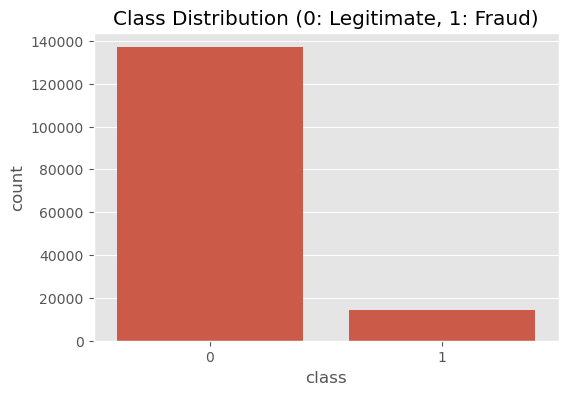

Legitimate Transactions: 90.64%
Fraudulent Transactions: 9.36%


In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')
plt.show()

imbalance_ratio = df['class'].value_counts(normalize=True) * 100
print(f"Legitimate Transactions: {imbalance_ratio[0]:.2f}%")
print(f"Fraudulent Transactions: {imbalance_ratio[1]:.2f}%")

#### Univariate Analysis
Objective: Distributions of key variables like Age and Purchase Value.

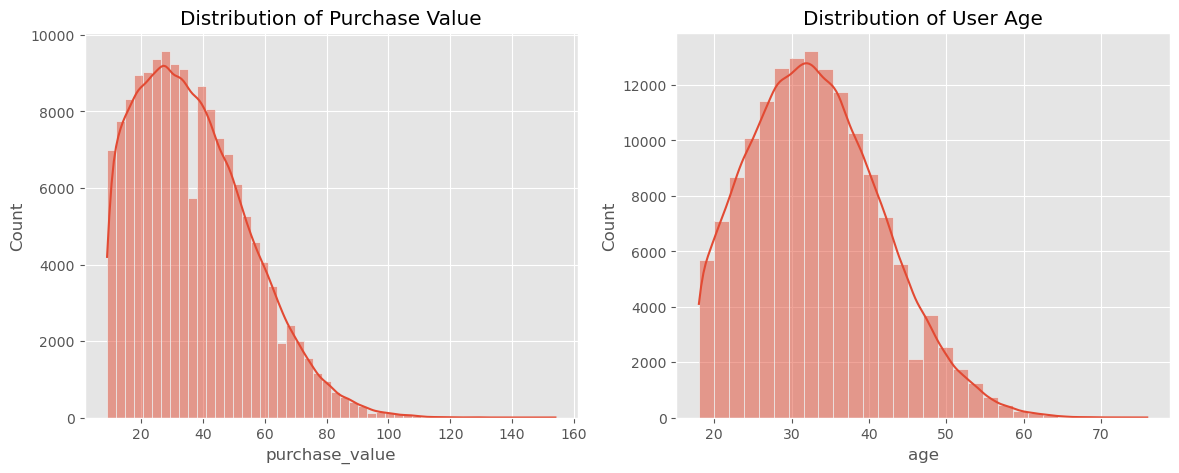

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Purchase Value Distribution
sns.histplot(df['purchase_value'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Purchase Value')

# Age Distribution
sns.histplot(df['age'], bins=30, kde=True, ax=ax[1])
ax[1].set_title('Distribution of User Age')

plt.show()

#### Bivariate Analysis
Objective: Relationships between features and the target (Fraud).

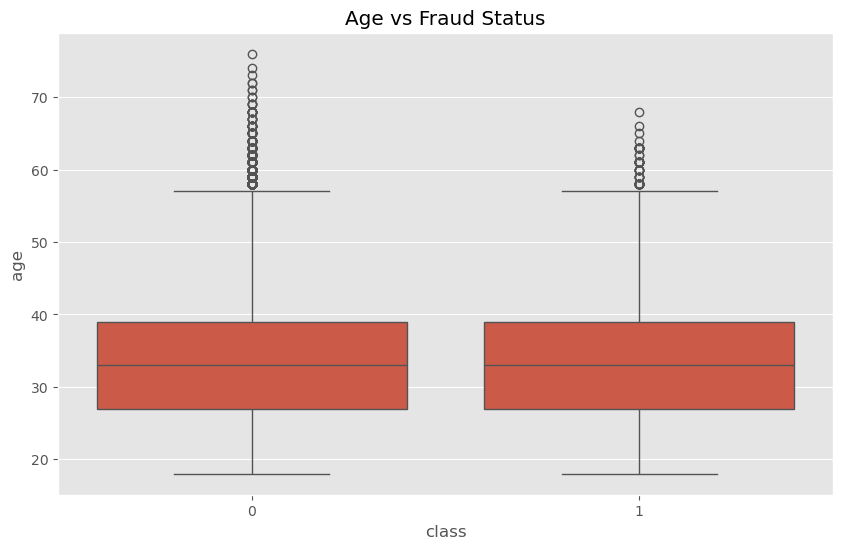

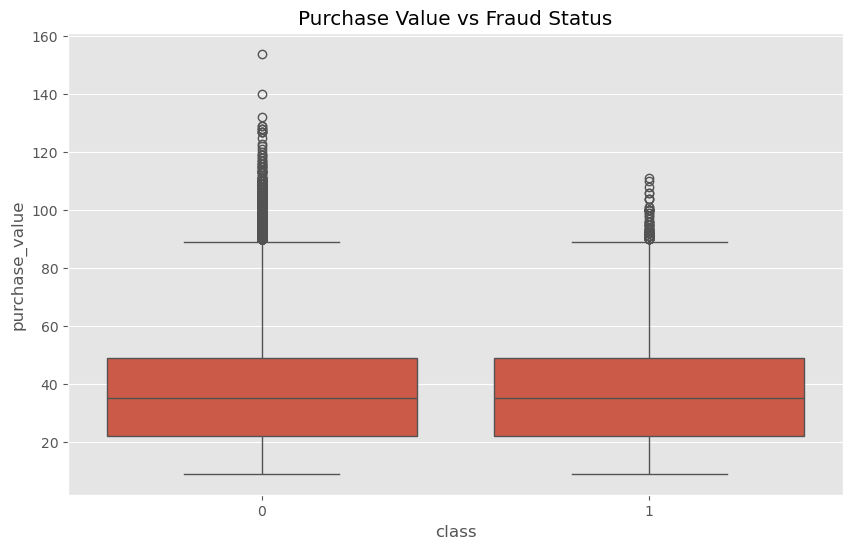

In [8]:
# Is there a specific age group more prone to fraud?
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='age', data=df)
plt.title('Age vs Fraud Status')
plt.show()

# Does purchase value correlate with fraud?
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=df)
plt.title('Purchase Value vs Fraud Status')
plt.show()

### Geolocation & Time Analysis
Objective: Identify patterns in countries and time of day.

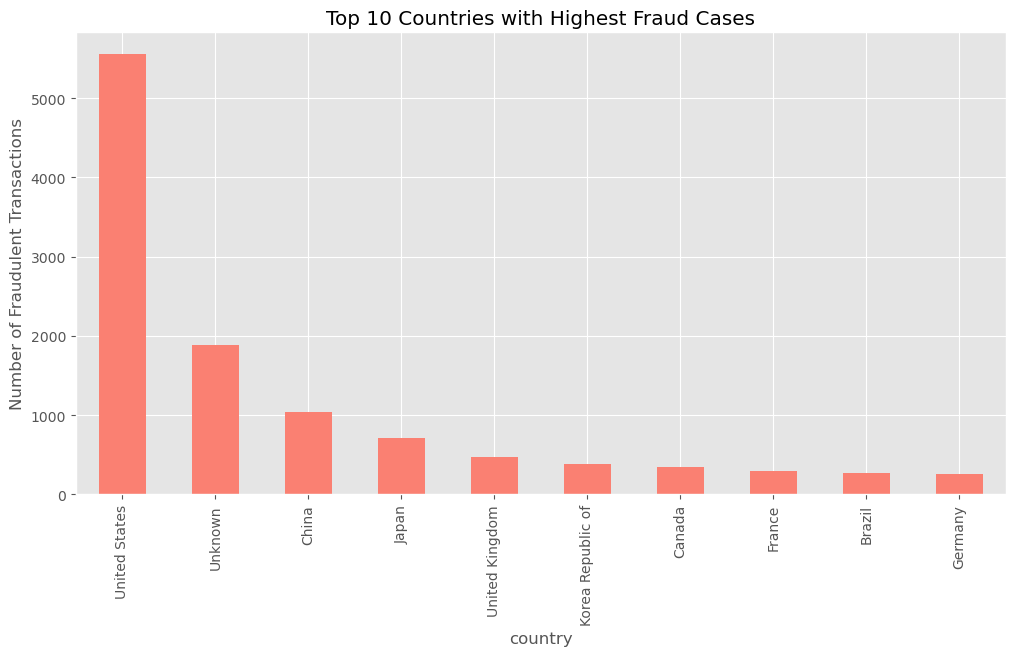

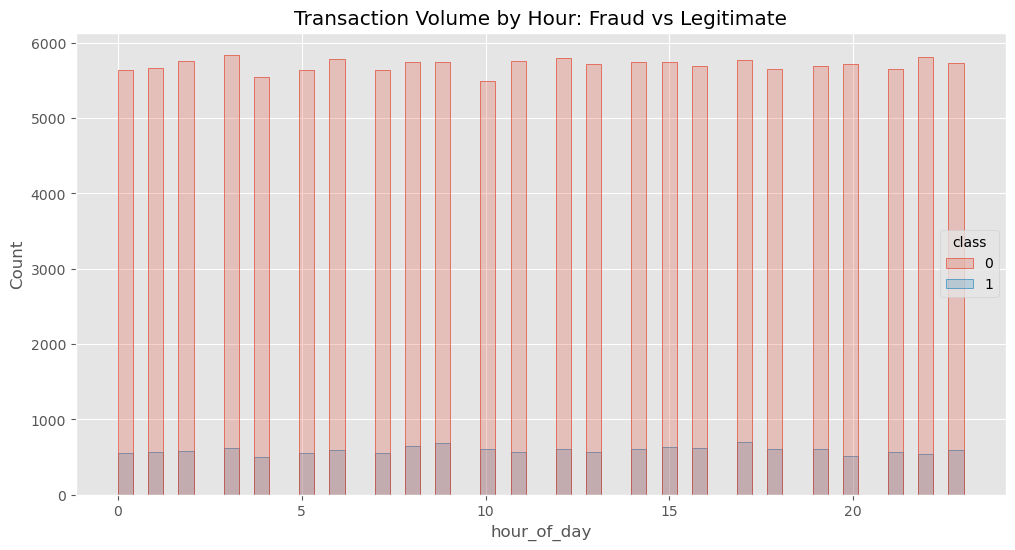

In [9]:
# Top 10 Countries by Fraud Count
fraud_only = df[df['class'] == 1]
top_fraud_countries = fraud_only['country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_fraud_countries.plot(kind='bar', color='salmon')
plt.title('Top 10 Countries with Highest Fraud Cases')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

# Fraud by Hour of Day
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='hour_of_day', hue='class', element='step', common_norm=False)
plt.title('Transaction Volume by Hour: Fraud vs Legitimate')
plt.show()

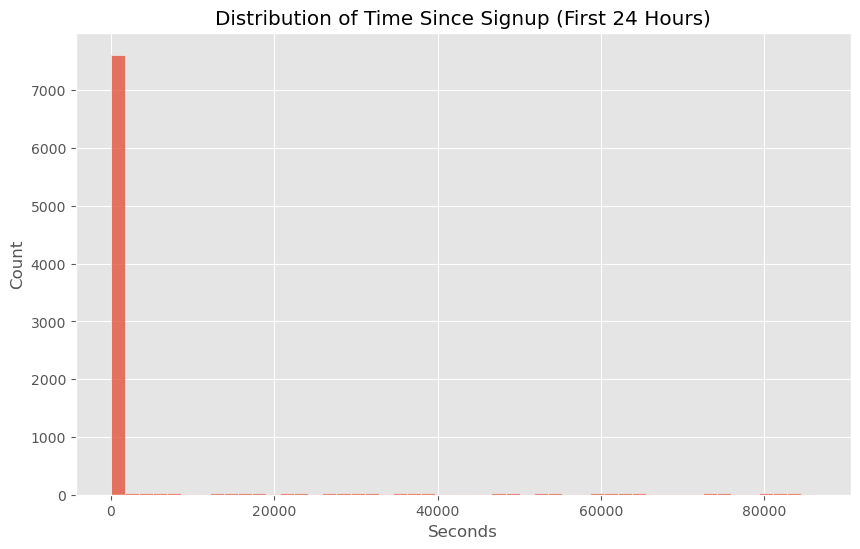

In [10]:
plt.figure(figsize=(10, 6))
# Focus on the first 24 hours (86400 seconds) to see the "Instant Purchase" pattern
sns.histplot(df[df['time_since_signup'] < 86400]['time_since_signup'], bins=50)
plt.title('Distribution of Time Since Signup (First 24 Hours)')
plt.xlabel('Seconds')
plt.show()

### Data Transformation

In [ ]:
# Select features for the model
features = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 
            'day_of_week', 'device_count', 'ip_count', 'source', 'browser', 'sex']

X = fraud_df[features]
y = fraud_df['class']

# Define which columns are categorical and which are numerical
cat_cols = ['source', 'browser', 'sex']
num_cols = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 'day_of_week', 'device_count', 'ip_count']

# Create transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

X_processed = preprocessor.fit_transform(X)

In [ ]:
# 1. Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# 2. Apply SMOTE to training data only
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Original training shape: {y_train.value_counts()}")
print(f"Resampled training shape: {y_train_res.value_counts()}")